In [ ]:
import numpy as np
import PIL.Image

import torch, torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from matplotlib import pyplot as plt

import os


image_size = 124
numero_de_epocas = 20
bs = 32
dataset = r'./data/Fer-2013/'
pasta_treino = os.path.join(dataset, 'treino')
pasta_validacao = os.path.join(dataset, 'validacao')
pasta_teste = os.path.join(dataset, 'teste')
numero_de_classes = len(os.listdir(pasta_validacao))

from torchvision import transforms

transformacoes_de_imagens = { 
    'treino': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.Resize(size=[image_size, image_size]),
        transforms.RandomRotation(20),
        transforms.Grayscale(num_output_channels=3), 
        transforms.ToTensor()
    ]),

    'validacao': transforms.Compose([
        transforms.Resize(size=[image_size, image_size]),
        transforms.Grayscale(num_output_channels=3),  
        transforms.ToTensor(),
    ])
}


data = {
    'treino': datasets.ImageFolder(root=pasta_treino, transform=transformacoes_de_imagens['treino']),
    'validacao': datasets.ImageFolder(root=pasta_validacao, transform=transformacoes_de_imagens['validacao'])
}

# Mapear os índices com os nomes das classes
indice_para_classe = {v: k for k, v in data['treino'].class_to_idx.items()}
print(indice_para_classe)

# Quantidade de imagens para serem utilizadas para calcular erro médio e acurácia
num_imagens_treino = len(data['treino'])
num_imagens_validacao = len(data['validacao'])

# Cria os DataLoaders para treino e validação
data_loader_treino = DataLoader(data['treino'], batch_size=bs, shuffle=True)
data_loader_validacao = DataLoader(data['validacao'], batch_size=bs, shuffle=True)

# Carregar o modelo ResNet-50 pré-treinado
resnet50 = models.resnet50(pretrained=True)

# Congelar os parâmetros da rede pré-treinada
for param in list(resnet50.parameters())[-4:]:
    param.requires_grad = True

# Modificar a última camada totalmente conectada (fc) para o número de classes do problema
num_features = resnet50.fc.in_features
resnet50.fc = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, numero_de_classes),
    nn.LogSoftmax(dim=1)
)

# Definir algoritmo de otimização e função de erro
funcao_erro = nn.NLLLoss()  # Negative Log Likelihood Loss
otimizador = optim.Adam(resnet50.parameters(), lr=0.0001)

# Função para treinamento e validação
from tqdm import tqdm

def treinar_e_validar(modelo, metrica_erro, otimizador_sgd, epocas=25):
    historico = []
    melhor_acuracia = 0.0
    melhor_modelo = None

    for epoca in range(epocas):
        inicio_epoca = time.time()
        print("\n\nÉpoca: {}/{}".format(epoca + 1, epocas))

        modelo.train()
        erro_treino = 0.0
        acuracia_treino = 0.0
        erro_validacao = 0.0
        acuracia_validacao = 0.0

        for i, (entradas, labels) in enumerate(tqdm(data_loader_treino, desc="Treinando")):
            entradas = entradas.to(device)
            labels = labels.to(device)

            otimizador_sgd.zero_grad()
            saidas = modelo(entradas)
            erro = metrica_erro(saidas, labels)
            erro.backward()
            otimizador_sgd.step()

            erro_treino += erro.item() * entradas.size(0)
            valores_maximos, indices_dos_valores_maximos = torch.max(saidas.data, 1)
            predicoes_corretas = indices_dos_valores_maximos.eq(labels.data.view_as(indices_dos_valores_maximos))
            acuracia = torch.mean(predicoes_corretas.type(torch.FloatTensor))
            acuracia_treino += acuracia.item() * entradas.size(0)

        # Dicionários para armazenar acertos e totais por classe
        acertos_por_classe = {classe: 0 for classe in indice_para_classe.values()}
        totais_por_classe = {classe: 0 for classe in indice_para_classe.values()}

        with torch.no_grad():
            modelo.eval()
            for j, (entradas, labels) in enumerate(tqdm(data_loader_validacao, desc="Validando")):
                entradas = entradas.to(device)
                labels = labels.to(device)
                saidas = modelo(entradas)
                erro = metrica_erro(saidas, labels)
                erro_validacao += erro.item() * entradas.size(0)

                valores_maximos, indices_dos_valores_maximos = torch.max(saidas.data, 1)
                predicoes_corretas = indices_dos_valores_maximos.eq(labels.data.view_as(indices_dos_valores_maximos))
                acuracia = torch.mean(predicoes_corretas.type(torch.FloatTensor))
                acuracia_validacao += acuracia.item() * entradas.size(0)

                # Atualizar contadores por classe
                for label, predicao in zip(labels, indices_dos_valores_maximos):
                    classe_real = indice_para_classe[label.item()]
                    totais_por_classe[classe_real] += 1
                    if label == predicao:
                        acertos_por_classe[classe_real] += 1

        erro_medio_treino = erro_treino / num_imagens_treino
        acuracia_media_treino = acuracia_treino / num_imagens_treino
        erro_medio_validacao = erro_validacao / num_imagens_validacao
        acuracia_media_validacao = acuracia_validacao / num_imagens_validacao

        historico.append([erro_medio_treino, erro_medio_validacao, acuracia_media_treino, acuracia_media_validacao])

        fim_epoca = time.time()

        print("Época : {:03d}, Treino: Erro: {:.4f}, Acurácia: {:.4f}%, \n\t\tValidação : Erro : {:.4f}, Acurácia: {:.4f}%, Tempo: {:.4f}s".format(
            epoca + 1, erro_medio_treino, acuracia_media_treino * 100, erro_medio_validacao, acuracia_media_validacao * 100, fim_epoca - inicio_epoca))



        print("\nAcurácia por classe na validação:")
        for classe, total in totais_por_classe.items():
            if total > 0:
                acuracia_classe = (acertos_por_classe[classe] / total) * 100
                print(f"Classe '{classe}': {acuracia_classe:.2f}%")
            else:
                print(f"Classe '{classe}': Sem exemplos na validação")

        if acuracia_media_validacao > melhor_acuracia:
            melhor_acuracia = acuracia_media_validacao
            torch.save(modelo, './melhores_modelos/melhor_modelo01k.pt')
            melhor_modelo = modelo

    return melhor_modelo, historico


# Se você for rico e tiver uma RTX 3080 (que sonho!!)
# Mas se não for, sem problemas, sua CPU provavelmente vai dar conta do recado!
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Imprime se vai ser CPU ou alguma GPU
print(f'{device}\n')

# Define o número de épocas
numero_de_epocas = 20

# treina o modelo! Finalmente!!
resnet50 = resnet50.to(device)
# modelo_treinado, historico = treinar_e_validar(resnet50, funcao_erro, otimizador, numero_de_epocas)


{0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Neutral', 5: 'Sad', 6: 'Surprise'}


c:\Users\Danil\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


cuda:0



In [102]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, f1_score

def validar_e_plotar_modelo(modelo, data_loader_teste, classes, device="cpu", titulo="Matriz de Confusão", cmap="Blues", figsize=(10, 8)):
    """
    Função para validar um modelo, calcular métricas e plotar a matriz de confusão.

    Args:
        modelo: Modelo PyTorch a ser validado.
        data_loader_teste: DataLoader com os dados de teste.
        classes: Lista com os nomes das classes.
        device: Dispositivo para execução ("cpu" ou "cuda").
        titulo: Título da matriz de confusão.
        cmap: Mapa de cores para o heatmap.
        figsize: Tamanho da figura do heatmap.

    Retorna:
        Nenhum. Apenas exibe os resultados e o gráfico.
    """
    # Listas para armazenar rótulos reais e previstos
    rotulos_reais = []
    rotulos_previstos = []

    # Avaliar o modelo nos dados de teste
    modelo.eval()
    with torch.no_grad():
        for entradas, labels in tqdm(data_loader_teste, desc="Validando"):
            entradas = entradas.to(device)
            labels = labels.to(device)

            # Obter as previsões do modelo
            saidas = modelo(entradas)
            valores_maximos, indices_dos_valores_maximos = torch.max(saidas.data, 1)

            # Armazenar rótulos reais e previstos
            rotulos_reais.extend(labels.cpu().numpy())
            rotulos_previstos.extend(indices_dos_valores_maximos.cpu().numpy())

    # Calcular a matriz de confusão
    matriz_confusao = confusion_matrix(rotulos_reais, rotulos_previstos)

    # Calcular métricas adicionais
    relatorio_classificacao = classification_report(rotulos_reais, rotulos_previstos, target_names=classes)
    acuracia = accuracy_score(rotulos_reais, rotulos_previstos)
    f1 = f1_score(rotulos_reais, rotulos_previstos, average='weighted')

    # Exibir métricas
    print("\nRelatório de Classificação:\n")
    print(relatorio_classificacao)
    print(f"Acurácia: {acuracia:.4f}")
    print(f"F1-Score: {f1:.4f}")

    # Plotar a matriz de confusão
    plt.figure(figsize=figsize)
    sns.heatmap(matriz_confusao, annot=True, fmt='d', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.xlabel('Classes previstas')
    plt.ylabel('Classes reais')
    plt.title(titulo)
    plt.show()


In [103]:

# Caminho do melhor modelo salvo
caminho_modelo = './melhores_modelos/melhor_modelo01k.pt'

# Carregar o modelo salvo
melhor_modelo = torch.load(caminho_modelo)
melhor_modelo = melhor_modelo.to(device)

# Transformação para os dados de teste
transformacao_teste = transforms.Compose([
    transforms.Resize(size=[image_size, image_size]),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()
])

# Carregar os dados de teste
dados_teste = datasets.ImageFolder(root=pasta_teste, transform=transformacao_teste)
data_loader_teste = DataLoader(dados_teste, batch_size=bs, shuffle=False)

# Mapear índices para os nomes das classes
nomes_das_classes = [indice_para_classe[i] for i in range(numero_de_classes)]

# Validar e plotar o modelo
# validar_e_plotar_modelo(melhor_modelo, data_loader_teste, nomes_das_classes, device)


C:\Users\Danil\AppData\Local\Temp\ipykernel_3344\1668232617.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  melhor_modelo = torch.load(caminho_modelo)


C:\Users\Danil\AppData\Local\Temp\ipykernel_3344\2561230512.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  modelo_treinado = torch.load(caminho_modelo)
Validando: 100%


Relatório de Classificação:

              precision    recall  f1-score   support

       Angry       0.37      0.41      0.39       491
     Disgust       0.00      0.00      0.00        55
        Fear       0.43      0.07      0.11       528
       Happy       0.73      0.58      0.65       879
     Neutral       0.33      0.62      0.43       626
         Sad       0.33      0.40      0.36       594
    Surprise       0.54      0.48      0.51       416

    accuracy                           0.44      3589
   macro avg       0.39      0.37      0.35      3589
weighted avg       0.47      0.44      0.42      3589

Acurácia: 0.4380
F1-Score: 0.4225


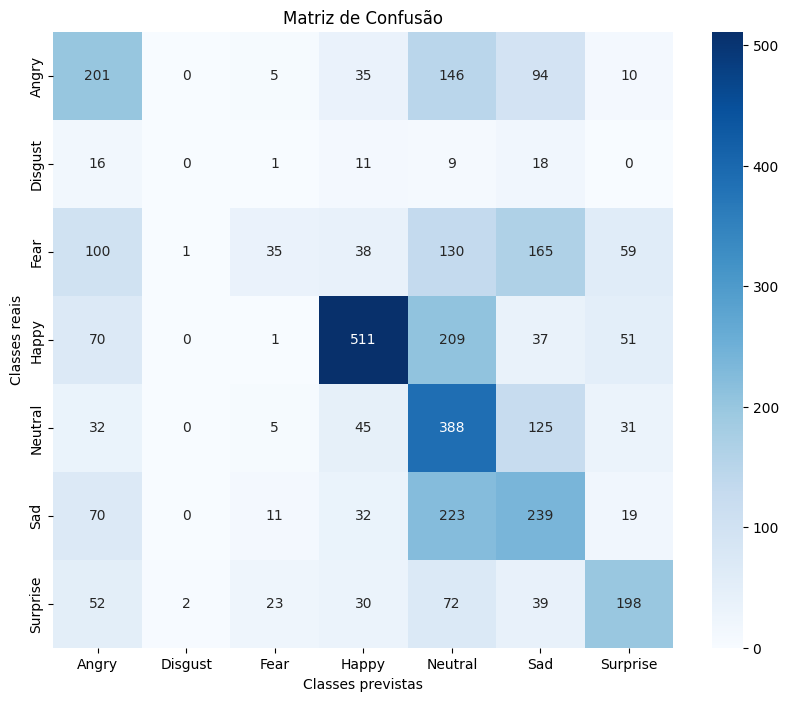

In [104]:
# Carregar o modelo salvo
definicoes_de_transformacoes = {
    'validacao': transforms.Compose([
        transforms.Resize(size=(image_size, image_size)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

caminho_modelo = './melhores_modelos/melhor_modelo001k.pt'
modelo_treinado = torch.load(caminho_modelo)
modelo_treinado = modelo_treinado.to(device)

# Preparar o DataLoader para o conjunto de teste
transformacoes_teste = definicoes_de_transformacoes['validacao']
dataset_teste = datasets.ImageFolder(root=pasta_teste, transform=transformacoes_teste)
data_loader_teste = DataLoader(dataset_teste, batch_size=bs, shuffle=False)

# Validar o modelo e plotar a matriz de confusão
classes = list(indice_para_classe.values())  # Nomes das classes
validar_e_plotar_modelo(modelo_treinado, data_loader_teste, classes, device=device)



testando com folds

c:\Users\Danil\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Danil\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\Danil\AppData\Local\Temp\ipykernel_3344\4286571165.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future 


Relatório de Classificação:

              precision    recall  f1-score   support

       Angry       0.58      0.62      0.60       491
     Disgust       0.55      0.71      0.62        55
        Fear       0.57      0.48      0.52       528
       Happy       0.90      0.86      0.88       879
     Neutral       0.68      0.64      0.66       626
         Sad       0.52      0.54      0.53       594
    Surprise       0.73      0.87      0.79       416

    accuracy                           0.68      3589
   macro avg       0.65      0.67      0.66      3589
weighted avg       0.68      0.68      0.68      3589

Acurácia: 0.6796
F1-Score: 0.6783


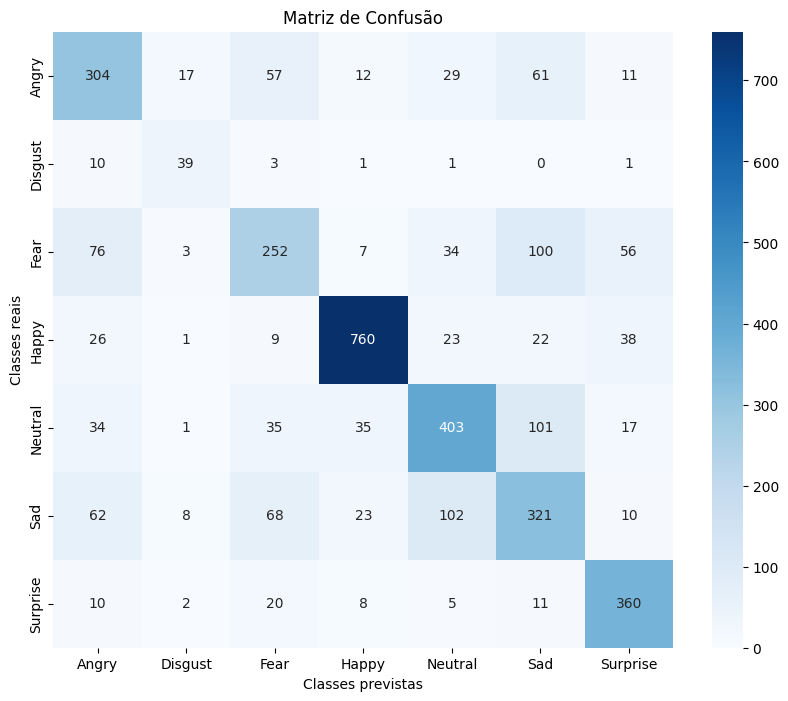

In [105]:
# Carregar o modelo salvo
caminho_modelo = './melhores_modelos/melhor_modelo_a1.pt'  # Altere para o fold ou modelo desejado
modelo_carregado = models.resnet50(pretrained=False)
num_features = modelo_carregado.fc.in_features
modelo_carregado.fc = nn.Sequential(
    nn.Linear(num_features, 1024),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, numero_de_classes),
    nn.LogSoftmax(dim=1)
)

# Carregar os pesos salvos no modelo
modelo_carregado.load_state_dict(torch.load(caminho_modelo))
modelo_carregado = modelo_carregado.to(device)

# Preparar o DataLoader para o conjunto de teste
transformacoes_teste = definicoes_de_transformacoes['validacao']
dataset_teste = datasets.ImageFolder(root=pasta_teste, transform=transformacoes_teste)
data_loader_teste = DataLoader(dataset_teste, batch_size=bs, shuffle=False)

# Validar o modelo e plotar a matriz de confusão
classes = list(indice_para_classe.values())  # Obter os nomes das classes
validar_e_plotar_modelo(modelo_carregado, data_loader_teste, classes, device=device)


c:\Users\Danil\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Danil\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\Danil\AppData\Local\Temp\ipykernel_3344\4286571165.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future 


Relatório de Classificação:

              precision    recall  f1-score   support

       Angry       0.58      0.62      0.60       491
     Disgust       0.55      0.71      0.62        55
        Fear       0.57      0.48      0.52       528
       Happy       0.90      0.86      0.88       879
     Neutral       0.68      0.64      0.66       626
         Sad       0.52      0.54      0.53       594
    Surprise       0.73      0.87      0.79       416

    accuracy                           0.68      3589
   macro avg       0.65      0.67      0.66      3589
weighted avg       0.68      0.68      0.68      3589

Acurácia: 0.6796
F1-Score: 0.6783


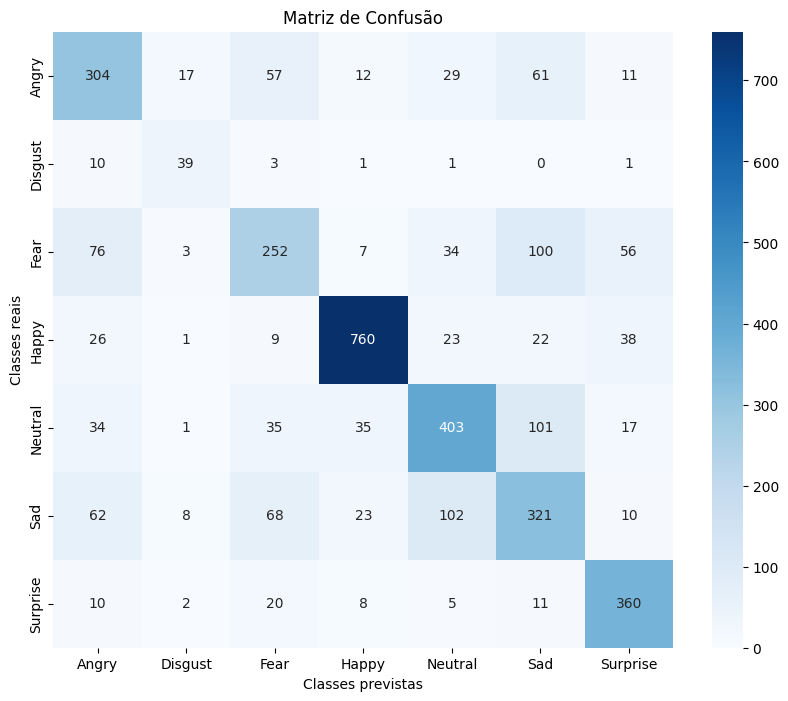

In [106]:
# Carregar o modelo salvo
caminho_modelo = './melhores_modelos/melhor_modelo_a1.pt'  # Altere para o fold ou modelo desejado
modelo_carregado = models.resnet50(pretrained=False)
num_features = modelo_carregado.fc.in_features
modelo_carregado.fc = nn.Sequential(
    nn.Linear(num_features, 1024),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, numero_de_classes),
    nn.LogSoftmax(dim=1)
)

# Carregar os pesos salvos no modelo
modelo_carregado.load_state_dict(torch.load(caminho_modelo))
modelo_carregado = modelo_carregado.to(device)

# Preparar o DataLoader para o conjunto de teste
transformacoes_teste = definicoes_de_transformacoes['validacao']
dataset_teste = datasets.ImageFolder(root=pasta_teste, transform=transformacoes_teste)
data_loader_teste = DataLoader(dataset_teste, batch_size=bs, shuffle=False)

# Validar o modelo e plotar a matriz de confusão
classes = list(indice_para_classe.values())  # Obter os nomes das classes
validar_e_plotar_modelo(modelo_carregado, data_loader_teste, classes, device=device)


c:\Users\Danil\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Danil\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\Danil\AppData\Local\Temp\ipykernel_3344\3086872764.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future 


Relatório de Classificação:

              precision    recall  f1-score   support

       Angry       0.62      0.59      0.61       491
     Disgust       0.70      0.73      0.71        55
        Fear       0.57      0.52      0.54       528
       Happy       0.90      0.86      0.88       879
     Neutral       0.66      0.68      0.67       626
         Sad       0.53      0.59      0.56       594
    Surprise       0.78      0.82      0.80       416

    accuracy                           0.69      3589
   macro avg       0.68      0.68      0.68      3589
weighted avg       0.69      0.69      0.69      3589

Acurácia: 0.6899
F1-Score: 0.6906


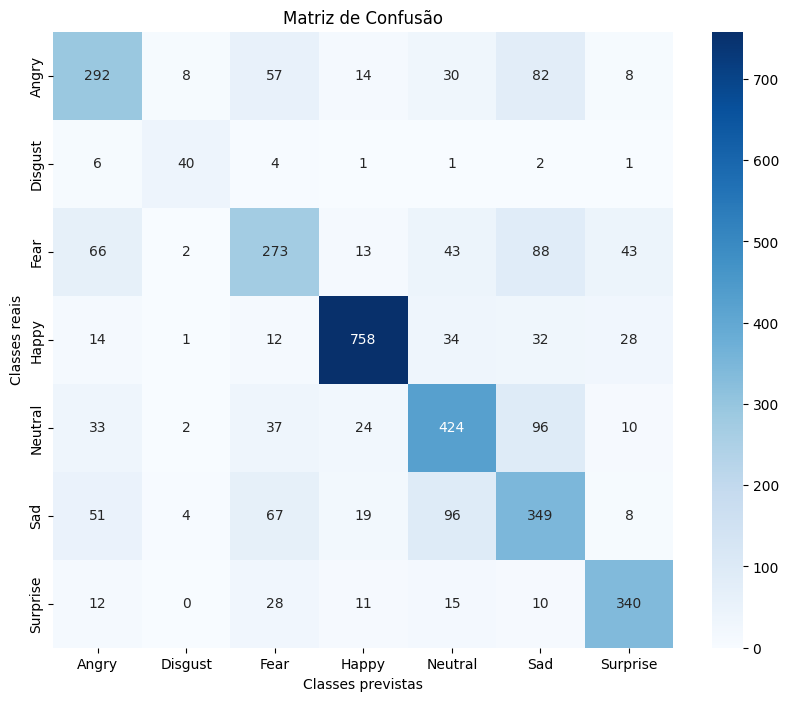

In [107]:
# Carregar o modelo salvo
caminho_modelo = './melhores_modelos/melhor_modelo_a2.pt'  # Altere para o fold ou modelo desejado
modelo_carregado = models.resnet50(pretrained=False)
num_features = modelo_carregado.fc.in_features
modelo_carregado.fc = nn.Sequential(
    nn.Linear(num_features, 1024),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, numero_de_classes),
    nn.LogSoftmax(dim=1)
)

# Carregar os pesos salvos no modelo
modelo_carregado.load_state_dict(torch.load(caminho_modelo))
modelo_carregado = modelo_carregado.to(device)

# Preparar o DataLoader para o conjunto de teste
transformacoes_teste = definicoes_de_transformacoes['validacao']
dataset_teste = datasets.ImageFolder(root=pasta_teste, transform=transformacoes_teste)
data_loader_teste = DataLoader(dataset_teste, batch_size=bs, shuffle=False)

# Validar o modelo e plotar a matriz de confusão
classes = list(indice_para_classe.values())  # Obter os nomes das classes
validar_e_plotar_modelo(modelo_carregado, data_loader_teste, classes, device=device)


c:\Users\Danil\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Danil\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\Danil\AppData\Local\Temp\ipykernel_3344\3305274103.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future 


Relatório de Classificação:

              precision    recall  f1-score   support

       Angry       0.61      0.62      0.62       491
     Disgust       0.65      0.75      0.69        55
        Fear       0.61      0.55      0.58       528
       Happy       0.88      0.86      0.87       879
     Neutral       0.64      0.73      0.68       626
         Sad       0.58      0.52      0.54       594
    Surprise       0.78      0.83      0.80       416

    accuracy                           0.70      3589
   macro avg       0.68      0.69      0.68      3589
weighted avg       0.70      0.70      0.70      3589

Acurácia: 0.6980
F1-Score: 0.6960


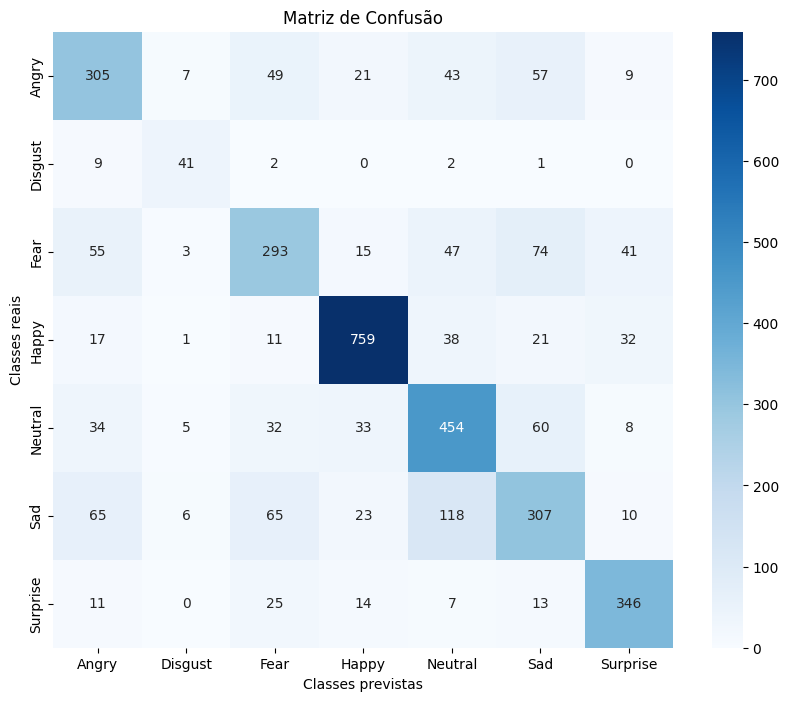

In [108]:
# Carregar o modelo salvo
caminho_modelo = './melhores_modelos/melhor_modelo_a3.pt'  # Altere para o fold ou modelo desejado
modelo_carregado = models.resnet50(pretrained=False)
num_features = modelo_carregado.fc.in_features
modelo_carregado.fc = nn.Sequential(
    nn.Linear(num_features, 1024),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, numero_de_classes),
    nn.LogSoftmax(dim=1)
)

# Carregar os pesos salvos no modelo
modelo_carregado.load_state_dict(torch.load(caminho_modelo))
modelo_carregado = modelo_carregado.to(device)

# Preparar o DataLoader para o conjunto de teste
transformacoes_teste = definicoes_de_transformacoes['validacao']
dataset_teste = datasets.ImageFolder(root=pasta_teste, transform=transformacoes_teste)
data_loader_teste = DataLoader(dataset_teste, batch_size=bs, shuffle=False)

# Validar o modelo e plotar a matriz de confusão
classes = list(indice_para_classe.values())  # Obter os nomes das classes
validar_e_plotar_modelo(modelo_carregado, data_loader_teste, classes, device=device)


c:\Users\Danil\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Danil\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\Danil\AppData\Local\Temp\ipykernel_3344\2899439025.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future 


Relatório de Classificação:

              precision    recall  f1-score   support

       Angry       0.62      0.59      0.60       491
     Disgust       0.78      0.65      0.71        55
        Fear       0.61      0.51      0.56       528
       Happy       0.88      0.88      0.88       879
     Neutral       0.61      0.73      0.67       626
         Sad       0.52      0.53      0.53       594
    Surprise       0.83      0.81      0.82       416

    accuracy                           0.69      3589
   macro avg       0.69      0.67      0.68      3589
weighted avg       0.69      0.69      0.69      3589

Acurácia: 0.6902
F1-Score: 0.6889


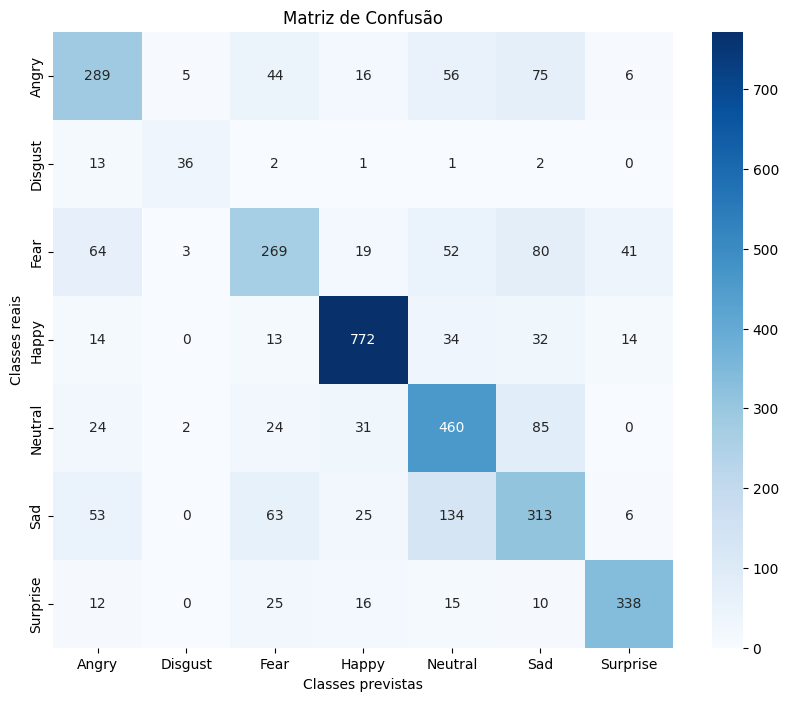

In [109]:
# Carregar o modelo salvo
caminho_modelo = './melhores_modelos/melhor_modelo_a4.pt'  # Altere para o fold ou modelo desejado
modelo_carregado = models.resnet50(pretrained=False)
num_features = modelo_carregado.fc.in_features
modelo_carregado.fc = nn.Sequential(
    nn.Linear(num_features, 1024),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, numero_de_classes),
    nn.LogSoftmax(dim=1)
)

# Carregar os pesos salvos no modelo
modelo_carregado.load_state_dict(torch.load(caminho_modelo))
modelo_carregado = modelo_carregado.to(device)

# Preparar o DataLoader para o conjunto de teste
transformacoes_teste = definicoes_de_transformacoes['validacao']
dataset_teste = datasets.ImageFolder(root=pasta_teste, transform=transformacoes_teste)
data_loader_teste = DataLoader(dataset_teste, batch_size=bs, shuffle=False)

# Validar o modelo e plotar a matriz de confusão
classes = list(indice_para_classe.values())  # Obter os nomes das classes
validar_e_plotar_modelo(modelo_carregado, data_loader_teste, classes, device=device)


testando outro modelo

C:\Users\Danil\AppData\Local\Temp\ipykernel_3344\1859711813.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  modelo_carregado.load_state_dict(torch.load(caminho_modelo))


Relatório de Classificação:

              precision    recall  f1-score   support

       Angry       0.29      0.00      0.01       491
     Disgust       0.00      0.00      0.00        55
        Fear       0.00      0.00      0.00       528
       Happy       0.39      0.04      0.07       879
     Neutral       0.25      0.15      0.19       626
         Sad       0.17      0.89      0.29       594
    Surprise       0.00      0.00      0.00       416

    accuracy                           0.18      3589
   macro avg       0.16      0.16      0.08      3589
weighted avg       0.20      0.18      0.10      3589

Acurácia: 0.1842
F1-Score: 0.0987


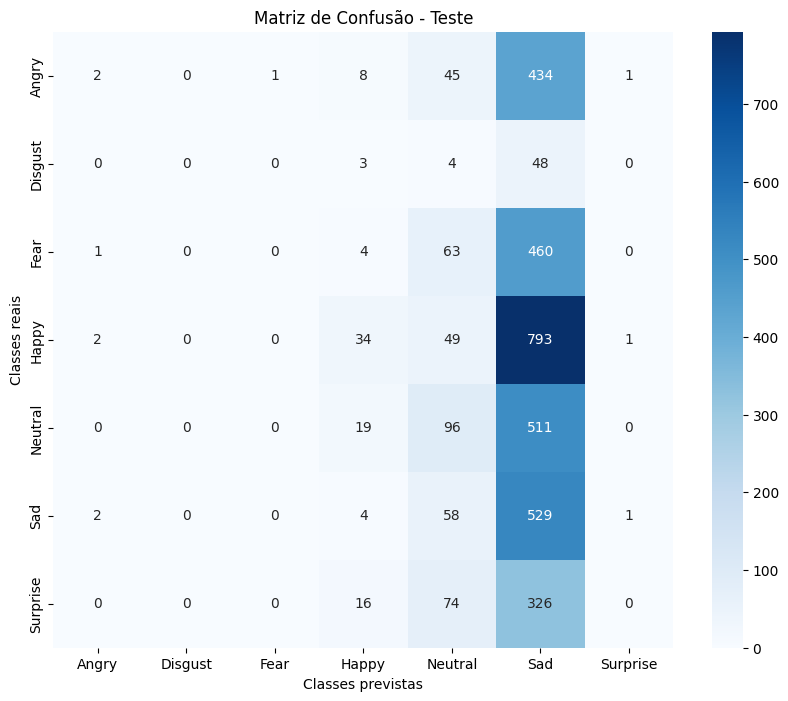

In [116]:
# Carregar o modelo salvo
caminho_modelo = './melhores_modelos/melhor_modelo_fold_4.pt'  # Ajuste o caminho para o modelo desejado
modelo_carregado = models.resnet50(pretrained=False)
num_features = modelo_carregado.fc.in_features
modelo_carregado.fc = nn.Sequential(
    nn.Linear(num_features, 1024),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, numero_de_classes),
    nn.LogSoftmax(dim=1)
)

# Carregar os pesos do modelo treinado
modelo_carregado.load_state_dict(torch.load(caminho_modelo))
modelo_carregado = modelo_carregado.to(device)

# Preparar o DataLoader para o conjunto de teste
transformacoes_teste = definicoes_de_transformacoes['validacao']
dataset_teste = datasets.ImageFolder(root=pasta_teste, transform=transformacoes_teste)
data_loader_teste = DataLoader(dataset_teste, batch_size=bs, shuffle=False)

# Validar o modelo e plotar a matriz de confusão
classes = list(indice_para_classe.values())  # Obter os nomes das classes
validar_e_plotar_modelo(modelo_carregado, data_loader_teste, classes, device=device, titulo="Matriz de Confusão - Teste")


c:\Users\Danil\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Danil\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\Danil\AppData\Local\Temp\ipykernel_3344\1128353118.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future 


Relatório de Classificação:

              precision    recall  f1-score   support

       Angry       0.62      0.54      0.58       491
     Disgust       0.54      0.71      0.61        55
        Fear       0.57      0.30      0.40       528
       Happy       0.85      0.89      0.87       879
     Neutral       0.59      0.73      0.65       626
         Sad       0.51      0.55      0.53       594
    Surprise       0.70      0.80      0.74       416

    accuracy                           0.66      3589
   macro avg       0.63      0.65      0.63      3589
weighted avg       0.65      0.66      0.65      3589

Acurácia: 0.6578
F1-Score: 0.6473


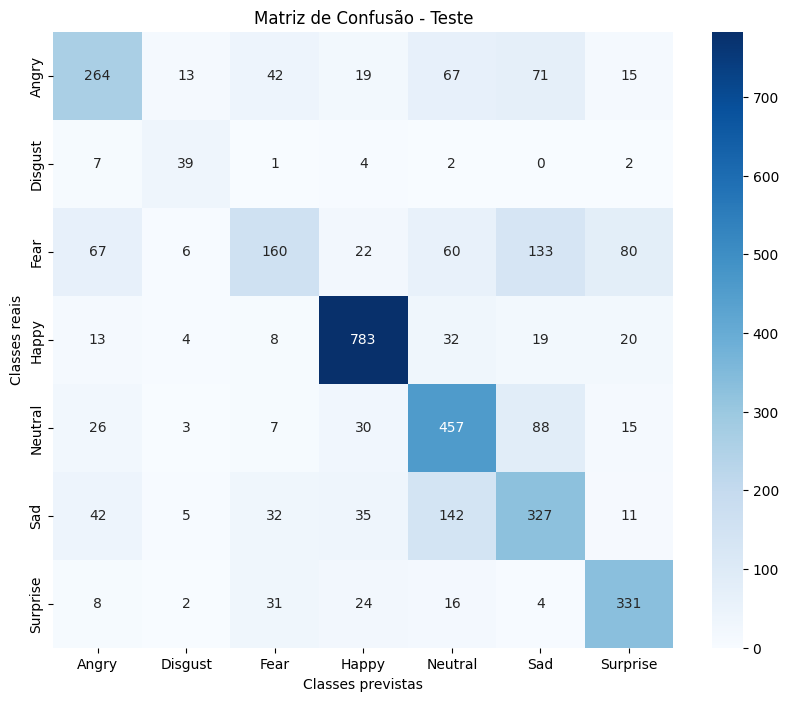

In [111]:
# Carregar o modelo salvo
caminho_modelo = './melhores_modelos/melhor_modelo_fold021.pt'  # Ajuste o caminho para o modelo desejado
modelo_carregado = models.resnet50(pretrained=False)
num_features = modelo_carregado.fc.in_features
modelo_carregado.fc = nn.Sequential(
    nn.Linear(num_features, 1024),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, numero_de_classes),
    nn.LogSoftmax(dim=1)
)

# Carregar os pesos do modelo treinado
modelo_carregado.load_state_dict(torch.load(caminho_modelo))
modelo_carregado = modelo_carregado.to(device)

# Preparar o DataLoader para o conjunto de teste
transformacoes_teste = definicoes_de_transformacoes['validacao']
dataset_teste = datasets.ImageFolder(root=pasta_teste, transform=transformacoes_teste)
data_loader_teste = DataLoader(dataset_teste, batch_size=bs, shuffle=False)

# Validar o modelo e plotar a matriz de confusão
classes = list(indice_para_classe.values())  # Obter os nomes das classes
validar_e_plotar_modelo(modelo_carregado, data_loader_teste, classes, device=device, titulo="Matriz de Confusão - Teste")


c:\Users\Danil\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Danil\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\Danil\AppData\Local\Temp\ipykernel_3344\3192361995.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future 


Relatório de Classificação:

              precision    recall  f1-score   support

       Angry       0.63      0.65      0.64       491
     Disgust       0.70      0.78      0.74        55
        Fear       0.55      0.48      0.51       528
       Happy       0.92      0.86      0.89       879
     Neutral       0.63      0.77      0.69       626
         Sad       0.58      0.52      0.55       594
    Surprise       0.73      0.81      0.77       416

    accuracy                           0.70      3589
   macro avg       0.68      0.69      0.69      3589
weighted avg       0.70      0.70      0.69      3589

Acurácia: 0.6952
F1-Score: 0.6934


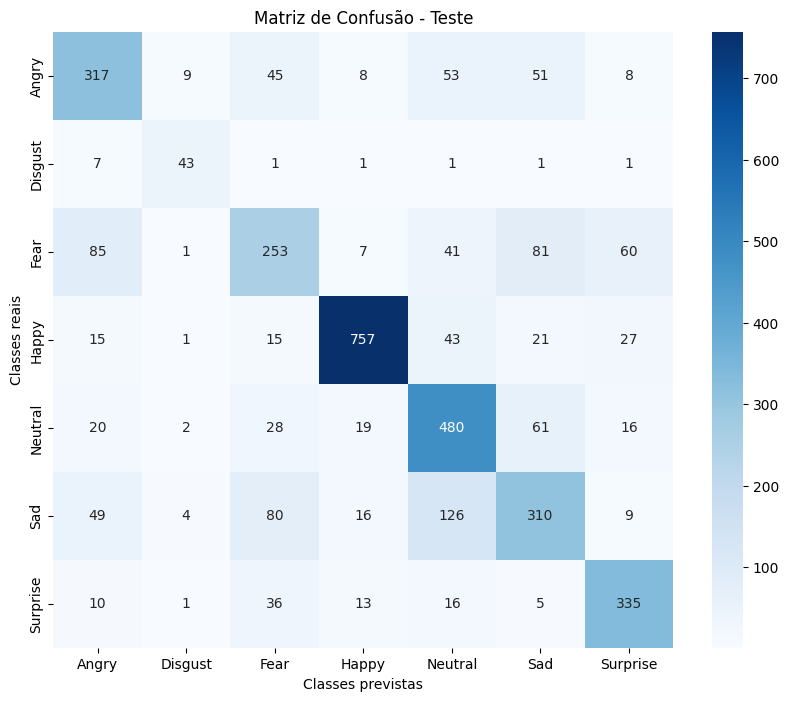

In [112]:
# Carregar o modelo salvo
caminho_modelo = './melhores_modelos/melhor_modelo_fold022.pt'  # Ajuste o caminho para o modelo desejado
modelo_carregado = models.resnet50(pretrained=False)
num_features = modelo_carregado.fc.in_features
modelo_carregado.fc = nn.Sequential(
    nn.Linear(num_features, 1024),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, numero_de_classes),
    nn.LogSoftmax(dim=1)
)

# Carregar os pesos do modelo treinado
modelo_carregado.load_state_dict(torch.load(caminho_modelo))
modelo_carregado = modelo_carregado.to(device)

# Preparar o DataLoader para o conjunto de teste
transformacoes_teste = definicoes_de_transformacoes['validacao']
dataset_teste = datasets.ImageFolder(root=pasta_teste, transform=transformacoes_teste)
data_loader_teste = DataLoader(dataset_teste, batch_size=bs, shuffle=False)

# Validar o modelo e plotar a matriz de confusão
classes = list(indice_para_classe.values())  # Obter os nomes das classes
validar_e_plotar_modelo(modelo_carregado, data_loader_teste, classes, device=device, titulo="Matriz de Confusão - Teste")


c:\Users\Danil\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Danil\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\Danil\AppData\Local\Temp\ipykernel_3344\896624529.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future r


Relatório de Classificação:

              precision    recall  f1-score   support

       Angry       0.61      0.65      0.63       491
     Disgust       0.75      0.76      0.76        55
        Fear       0.55      0.49      0.52       528
       Happy       0.90      0.87      0.89       879
     Neutral       0.66      0.72      0.69       626
         Sad       0.58      0.55      0.57       594
    Surprise       0.74      0.81      0.77       416

    accuracy                           0.70      3589
   macro avg       0.69      0.69      0.69      3589
weighted avg       0.70      0.70      0.70      3589

Acurácia: 0.6969
F1-Score: 0.6956


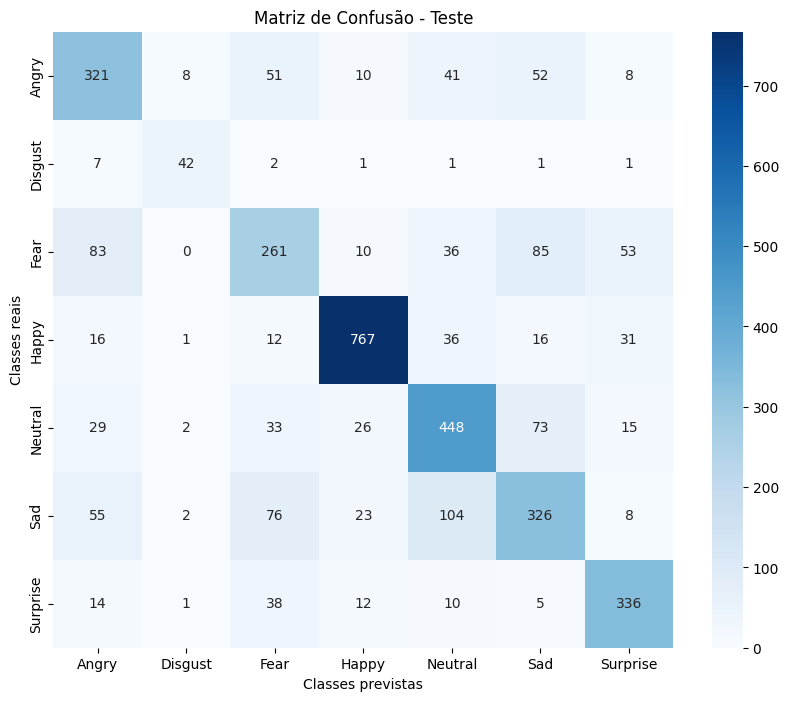

In [113]:
# Carregar o modelo salvo
caminho_modelo = './melhores_modelos/melhor_modelo_fold023.pt'  # Ajuste o caminho para o modelo desejado
modelo_carregado = models.resnet50(pretrained=False)
num_features = modelo_carregado.fc.in_features
modelo_carregado.fc = nn.Sequential(
    nn.Linear(num_features, 1024),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, numero_de_classes),
    nn.LogSoftmax(dim=1)
)

# Carregar os pesos do modelo treinado
modelo_carregado.load_state_dict(torch.load(caminho_modelo))
modelo_carregado = modelo_carregado.to(device)

# Preparar o DataLoader para o conjunto de teste
transformacoes_teste = definicoes_de_transformacoes['validacao']
dataset_teste = datasets.ImageFolder(root=pasta_teste, transform=transformacoes_teste)
data_loader_teste = DataLoader(dataset_teste, batch_size=bs, shuffle=False)

# Validar o modelo e plotar a matriz de confusão
classes = list(indice_para_classe.values())  # Obter os nomes das classes
validar_e_plotar_modelo(modelo_carregado, data_loader_teste, classes, device=device, titulo="Matriz de Confusão - Teste")


In [114]:
# Carregar o modelo salvo
caminho_modelo = './melhores_modelos/melhor_modelo_fold024.pt'  # Ajuste o caminho para o modelo desejado
modelo_carregado = models.resnet50(pretrained=False)
num_features = modelo_carregado.fc.in_features
modelo_carregado.fc = nn.Sequential(
    nn.Linear(num_features, 1024),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, numero_de_classes),
    nn.LogSoftmax(dim=1)
)

# Carregar os pesos do modelo treinado
modelo_carregado.load_state_dict(torch.load(caminho_modelo))
modelo_carregado = modelo_carregado.to(device)

# Preparar o DataLoader para o conjunto de teste
transformacoes_teste = definicoes_de_transformacoes['validacao']
dataset_teste = datasets.ImageFolder(root=pasta_teste, transform=transformacoes_teste)
data_loader_teste = DataLoader(dataset_teste, batch_size=bs, shuffle=False)

# Validar o modelo e plotar a matriz de confusão
classes = list(indice_para_classe.values())  # Obter os nomes das classes
validar_e_plotar_modelo(modelo_carregado, data_loader_teste, classes, device=device, titulo="Matriz de Confusão - Teste")


c:\Users\Danil\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Danil\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\Danil\AppData\Local\Temp\ipykernel_3344\1245191913.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future 

KeyboardInterrupt: 

c:\Users\Danil\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Danil\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\Danil\AppData\Local\Temp\ipykernel_3344\1897153140.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future 


Relatório de Classificação:

              precision    recall  f1-score   support

       Angry       0.63      0.64      0.64       491
     Disgust       0.71      0.76      0.74        55
        Fear       0.56      0.48      0.52       528
       Happy       0.91      0.87      0.89       879
     Neutral       0.64      0.75      0.69       626
         Sad       0.58      0.55      0.57       594
    Surprise       0.75      0.81      0.78       416

    accuracy                           0.70      3589
   macro avg       0.68      0.69      0.69      3589
weighted avg       0.70      0.70      0.70      3589

Acurácia: 0.6988
F1-Score: 0.6973


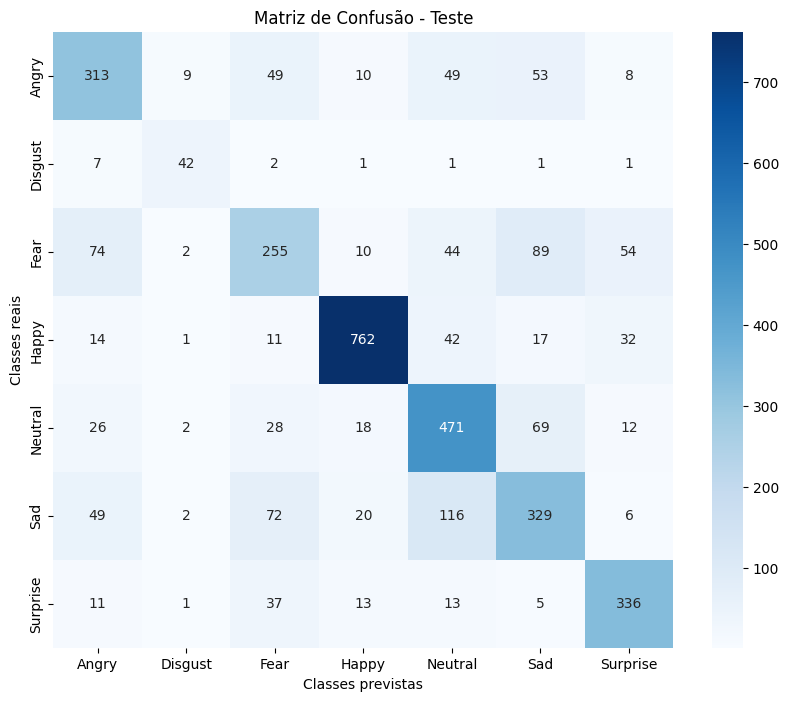

In [95]:
# Carregar o modelo salvo
caminho_modelo = './melhores_modelos/melhor_modelo_fold025.pt'  # Ajuste o caminho para o modelo desejado
modelo_carregado = models.resnet50(pretrained=False)
num_features = modelo_carregado.fc.in_features
modelo_carregado.fc = nn.Sequential(
    nn.Linear(num_features, 1024),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, numero_de_classes),
    nn.LogSoftmax(dim=1)
)

# Carregar os pesos do modelo treinado
modelo_carregado.load_state_dict(torch.load(caminho_modelo))
modelo_carregado = modelo_carregado.to(device)

# Preparar o DataLoader para o conjunto de teste
transformacoes_teste = definicoes_de_transformacoes['validacao']
dataset_teste = datasets.ImageFolder(root=pasta_teste, transform=transformacoes_teste)
data_loader_teste = DataLoader(dataset_teste, batch_size=bs, shuffle=False)

# Validar o modelo e plotar a matriz de confusão
classes = list(indice_para_classe.values())  # Obter os nomes das classes
validar_e_plotar_modelo(modelo_carregado, data_loader_teste, classes, device=device, titulo="Matriz de Confusão - Teste")
